# Figure2(Stackedbar) for tag

In [1]:
# create table tt_tag_proportion as
# select to_char(xx.creationdate, 'yyyy-mm-dd') as cdate , xx.id, xx.tag, xx.cnt, yy.tot_cnt, xx.cnt::FLOAT /yy.tot_cnt as pct
#   from (
#        select creationdate, id, tags, replace(replace(unnest(string_to_array(tags, '><')), '<', ''), '>', '') tag, 1 as cnt
#         from public.posts
#         where posttypeid = '1'
#           and creationdate between '2021-11-30' and '2023-12-01'
#           and tags like '%<python>%'

#            ) xx,
#        (
#            select x.id, count(x.tag) as tot_cnt
#               from (select creationdate, id, tags, replace(replace(unnest(string_to_array(tags, '><')), '<', ''), '>', '') tag
#                       from public.posts
#                     where posttypeid = '1'
#                       and creationdate between '2021-11-30' and '2023-12-01'
#                       and tags like '%<python>%') x
#             group by x.id

#            )yy
# where xx.id = yy.id
# ;

In [2]:
import sys, os
p = os.path.abspath('..')
sys.path.insert(1, p)

pp = os.path.abspath('../../visualization')
sys.path.insert(1, pp)

In [3]:
from gc import collect

from utils.statistics import *
from utils.settings import set_matplotlib
from distribution_collector import (collect_topic_distributions,
                                get_top_and_bottom_topics,
                                extract_specific_topics)
from constants import CONSTANTS
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib as mpl

import psycopg2
import pandas as pd
import numpy as np
from utils.statistics import *
import config.config as conf
import datetime
import re
# 포뮬러 구성
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd


In [4]:
from matplotlib import font_manager
import matplotlib as mpl
from matplotlib import font_manager as fm

# 설치된 폰트 이름과 경로 확인
for font in font_manager.fontManager.ttflist:
    if 'Helvetica' in font.name: # 'Nanum' 대신 원하는 글꼴의 일부를 입력하여 검색할 수 있습니다.
        print(font.name, font.fname)

# 직접 경로로 Helvetica 폰트 불러오기
font_path = "/System/Library/Fonts/Helvetica.ttc"
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
print(f"Registered font name: {font_name}")

mpl.rcParams['font.family'] = font_name


Helvetica /System/Library/Fonts/Helvetica.ttc
Helvetica Neue /System/Library/Fonts/HelveticaNeue.ttc
Registered font name: Helvetica


In [5]:
output_dir = './fig/'

In [6]:
conn = psycopg2.connect(host = conf.database_user['host'], dbname=conf.database_user['dbname'], user=conf.database_user['user'], password=conf.database_user['password'])
try:
    cur = conn.cursor()
    cur.execute("\
           select * \
           from tt_tag_proportion a \
; \
                " 
   )
    rows = cur.fetchall()
    

except psycopg2.DatabaseError as db_err:
    print(db_err)
finally : 
  cur.close()

In [7]:
df = pd.DataFrame(rows, columns = [
  'cdate' 
, 'id' 
, 'tag'
, 'cnt'
, 'tot_cnt'
, 'pct'
])

In [8]:
conn = psycopg2.connect(host = conf.database_user['host'], dbname=conf.database_user['dbname'], user=conf.database_user['user'], password=conf.database_user['password'])
try:
    cur = conn.cursor()
    cur.execute("\
           select * \
           from tt_tag_proportio_for_did a \
; \
                " 
   )
    rows = cur.fetchall()
    

except psycopg2.DatabaseError as db_err:
    print(db_err)
finally : 
  cur.close()

In [9]:
df_did = pd.DataFrame(rows, columns = [
  'cdate' 
, 'id' 
, 'tag'
, 'cnt'
, 'tot_cnt'
, 'pct'
])

In [10]:
std_date = datetime.datetime(2022, 11, 30)
pre_std_date = datetime.datetime(2021, 12, 1)

In [11]:
df['cdate'] = pd.to_datetime(df['cdate'], format="%Y-%m-%d")
df_did['cdate'] = pd.to_datetime(df_did['cdate'], format="%Y-%m-%d")

In [12]:
df['rel_week'] = np.floor((df['cdate']-std_date).dt.days/7)

df_did['post_rel_week'] = np.floor((df_did['cdate']-std_date).dt.days/7)
df_did['pre_rel_week'] = np.floor((df_did['cdate']-pre_std_date).dt.days/7)

In [13]:
df_bf_pro = df[df['rel_week']<0].groupby(['tag']).sum(['pct'])['pct'].sort_values().reset_index()

In [14]:
tagnum = int(np.floor(df_bf_pro.shape[0]*0.2))

In [15]:
tagnum

2578

In [16]:
bot_tag = list(df_bf_pro.iloc[:tagnum, 0])
top_tag = list(df_bf_pro.iloc[tagnum:, 0])

In [17]:
df_tot = df.groupby(['rel_week']).sum(['pct'])['pct'].reset_index(name = 'tot_pct')

In [18]:
df_pct = pd.merge(df, df_tot, on = 'rel_week')


In [19]:
df_pct['pct_pct'] = df_pct['pct']/df_pct['tot_pct']

In [20]:
df_pct_bot = df_pct[df_pct['tag'].isin(bot_tag)]
df_pct_top = df_pct[df_pct['tag'].isin(top_tag)]



df_pct_bot_did = df_did[df_did['tag'].isin(bot_tag)]
df_pct_top_did = df_did[df_did['tag'].isin(top_tag)]

In [21]:
df_pct_bot_did.head()

,cdate,id,tag,cnt,tot_cnt,pct,post_rel_week,pre_rel_week
21,2023-10-01,77210038,google-meet,1,5,0.200000,43.0,95.0
285,2023-09-29,77203040,shopee,1,4,0.250000,43.0,95.0
857,2023-11-13,77473445,parallel-ssh,1,5,0.200000,49.0,101.0
911,2023-11-12,77468308,azure-ai,1,5,0.200000,49.0,101.0
1004,2023-11-12,77469944,appkit,1,3,0.333333,49.0,101.0


In [22]:
df_pct_top_tot = df_pct_top.groupby(['rel_week']).sum(['pct_pct'])['pct_pct'].reset_index()
df_pct_bot_tot = df_pct_bot.groupby(['rel_week']).sum(['pct_pct'])['pct_pct'].reset_index()

df_pct_top_did_bd = df_pct_top_did.groupby(['cdate', 'pre_rel_week', 'post_rel_week']).sum(['pct'])['pct'].reset_index()
df_pct_bot_did_bd = df_pct_bot_did.groupby(['cdate', 'pre_rel_week', 'post_rel_week']).sum(['pct'])['pct'].reset_index()


In [23]:
df_pct_top_did_bd.head()

,cdate,pre_rel_week,post_rel_week,pct
0,2021-01-01,-48.0,-100.0,438.700000
1,2021-01-02,-48.0,-100.0,550.550000
2,2021-01-03,-48.0,-100.0,572.966667
3,2021-01-04,-48.0,-100.0,741.300000
4,2021-01-05,-48.0,-100.0,784.883333


In [24]:
df_top_post = df_pct_top_did_bd[(df_pct_top_did_bd['post_rel_week'] >=-20) & (df_pct_top_did_bd['post_rel_week'] <20)  ]
df_top_pre = df_pct_top_did_bd[(df_pct_top_did_bd['pre_rel_week'] >=-20) & (df_pct_top_did_bd['pre_rel_week'] <20)  ]

In [25]:
df_bot_post =   df_pct_bot_did_bd[(df_pct_bot_did_bd['post_rel_week'] >=-20) & (df_pct_bot_did_bd['post_rel_week'] <20)  ]
df_bot_pre =    df_pct_bot_did_bd[(df_pct_bot_did_bd['pre_rel_week'] >=-20) & (df_pct_bot_did_bd['pre_rel_week'] <20)  ]

In [26]:
df_bot_post['treated'] = 1
df_bot_pre['treated'] = 0

df_top_post['treated'] = 1
df_top_pre['treated'] = 0

/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_9299/1429258217.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bot_post['treated'] = 1
/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_9299/1429258217.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bot_pre['treated'] = 0
/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_9299/1429258217.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [27]:
df_bot_post['post'] = np.where(df_bot_post['post_rel_week']<0, 0, 1)
df_top_post['post'] = np.where(df_top_post['post_rel_week']<0, 0, 1)


df_bot_pre['post'] = np.where(df_bot_pre['pre_rel_week']<0, 0, 1)
df_top_pre['post'] = np.where(df_top_pre['pre_rel_week']<0, 0, 1)

/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_9299/1438422369.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bot_post['post'] = np.where(df_bot_post['post_rel_week']<0, 0, 1)
/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_9299/1438422369.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_post['post'] = np.where(df_top_post['post_rel_week']<0, 0, 1)
/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_9299/1438422369.py:5: SettingWithCopyWarning: 
A value is try

In [28]:
df_bot_post = df_bot_post.rename(columns= {'post_rel_week':'rel_week'})
df_top_post = df_top_post.rename(columns= {'post_rel_week':'rel_week'})


df_bot_pre = df_bot_pre.rename(columns= {'pre_rel_week':'rel_week'})
df_top_pre = df_top_pre.rename(columns= {'pre_rel_week':'rel_week'})

In [29]:
df_bot_pre.head()

,cdate,rel_week,post_rel_week,pct,treated,post
194,2021-07-14,-20.0,-72.0,3.233333,0,0
195,2021-07-15,-20.0,-72.0,2.533333,0,0
196,2021-07-16,-20.0,-72.0,1.683333,0,0
197,2021-07-18,-20.0,-72.0,0.400000,0,0
198,2021-07-19,-20.0,-72.0,1.683333,0,0


In [30]:
df_bot_for_did = pd.concat([df_bot_post[['rel_week', 'pct', 'treated', 'post']], df_bot_pre[['rel_week', 'pct', 'treated', 'post']]])
df_top_for_did = pd.concat([df_top_post[['rel_week', 'pct', 'treated', 'post']], df_top_pre[['rel_week', 'pct', 'treated', 'post']]])

In [31]:
df_bot_for_did[df_bot_for_did['rel_week'] ==-15.0]

,rel_week,pct,treated,post
591,-15.0,1.850000,1,0
592,-15.0,1.850000,1,0
593,-15.0,2.150000,1,0
594,-15.0,1.100000,1,0
595,-15.0,0.800000,1,0
596,-15.0,3.200000,1,0
597,-15.0,1.450000,1,0
228,-15.0,0.950000,0,0
229,-15.0,1.383333,0,0
230,-15.0,1.500000,0,0


In [32]:
def calc_did(data, measure):
    data['rel_week'] = data['rel_week'].astype('category')
    # 회귀식: 주차별 상호작용 포함
    model = smf.ols(f"{measure} ~ C(rel_week) * treated", data=data)
    did_result = model.fit(cov_type='HAC', cov_kwds={'maxlags': 7}) 

    return did_result

In [35]:
def pp_did_result(did_result) :
    # 결과 정리
    periods = np.arange(-19,19, 1)
    coefs = did_result.params
    std_errors = did_result.bse 
    conf = did_result.conf_int()
    print(coefs)
    coefs_filtered      = coefs.loc[[f'C(rel_week)[T.{i}.0]:treated' for i in periods]].values
    std_errors_filtered = std_errors.loc[[f'C(rel_week)[T.{i}.0]:treated' for i in periods]].values

    # 신뢰구간 계산
    ll_95 = coefs_filtered - 1.965 * std_errors_filtered
    ul_95 = coefs_filtered + 1.965 * std_errors_filtered

    # 데이터프레임 생성 (계수와 신뢰구간)
    df_coefs = pd.DataFrame({
        'period'    : periods,
        'Estimate'  : coefs_filtered,
        'll_95'     : ll_95,
        'ul_95'     : ul_95
    })
    return df_coefs




In [36]:
top_did_result = calc_did(df_top_for_did, 'pct')
bot_did_result = calc_did(df_bot_for_did , 'pct')

top_event_effects = pp_did_result(top_did_result)
bot_event_effects = pp_did_result(bot_did_result)


Intercept                      661.428571
C(rel_week)[T.-19.0]             8.066667
C(rel_week)[T.-18.0]            -8.633333
C(rel_week)[T.-17.0]           -23.288095
C(rel_week)[T.-16.0]           -15.257143
                                  ...    
C(rel_week)[T.15.0]:treated   -172.697619
C(rel_week)[T.16.0]:treated   -182.647619
C(rel_week)[T.17.0]:treated   -199.407143
C(rel_week)[T.18.0]:treated   -253.088095
C(rel_week)[T.19.0]:treated   -184.869048
Length: 80, dtype: float64
Intercept                      1.927778
C(rel_week)[T.-19.0]          -0.465873
C(rel_week)[T.-18.0]          -0.087302
C(rel_week)[T.-17.0]          -0.406349
C(rel_week)[T.-16.0]          -0.330159
                                 ...   
C(rel_week)[T.15.0]:treated    0.484921
C(rel_week)[T.16.0]:treated    0.693651
C(rel_week)[T.17.0]:treated    0.207937
C(rel_week)[T.18.0]:treated    0.392063
C(rel_week)[T.19.0]:treated    0.434921
Length: 80, dtype: float64


In [37]:
event_effects_dict = dict()
event_effects_dict['top'] = top_event_effects
event_effects_dict['bot'] = bot_event_effects

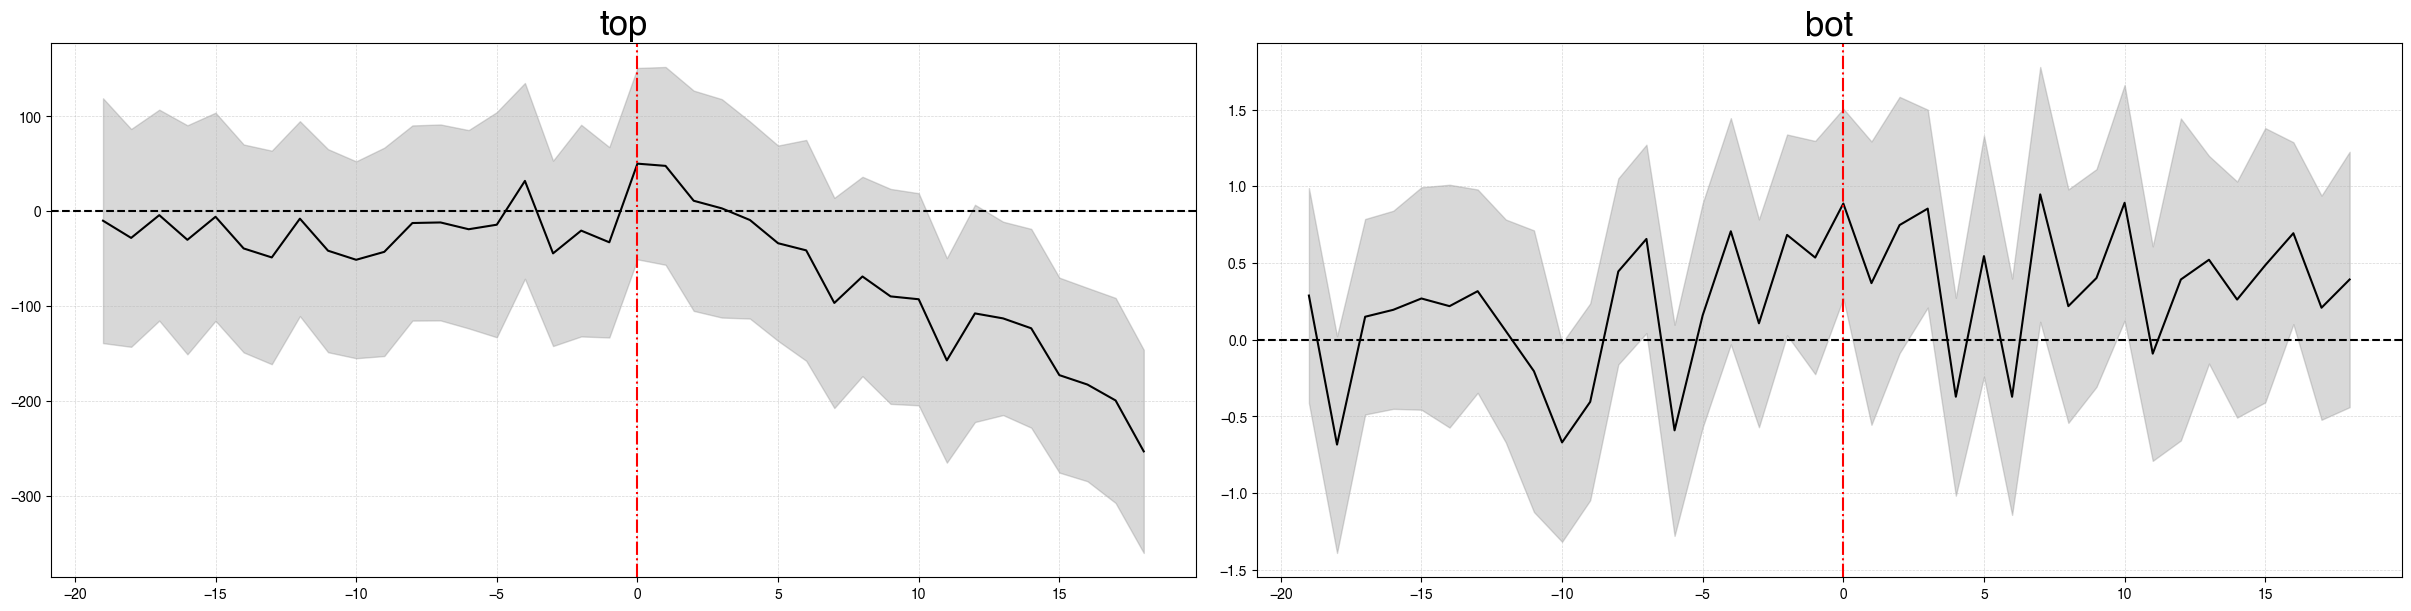

In [38]:
# 신뢰구간 영역
fig, axs = plt.subplots(1, 2, figsize = (24, 6), constrained_layout=True)
colors = plt.get_cmap('tab20').colors 

for idx, measure in enumerate(event_effects_dict):
    # idx+=2

    axs[idx].fill_between(event_effects_dict[measure]['period'], event_effects_dict[measure]['ll_95'], event_effects_dict[measure]['ul_95'], color='gray', alpha=0.3)
    axs[idx].plot(event_effects_dict[measure]['period'], event_effects_dict[measure]['Estimate'], color='black', label='DID Estimate')

    # 기준선
    axs[idx].axhline(0, linestyle='--', color='black')
    axs[idx].axvline(0, linestyle='dashdot', color='red', label='ChatGPT Release')

    # 축 라벨과 제목
    axs[idx].set_title(f"{measure}", fontsize=25)
    axs[idx].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

In [39]:
proportion_dict = {'Most Frequently Assigned Tags' : df_pct_top_tot
                ,   'Least Frequently Assigned Tags' : df_pct_bot_tot}


/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_9299/3421815253.py:26: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


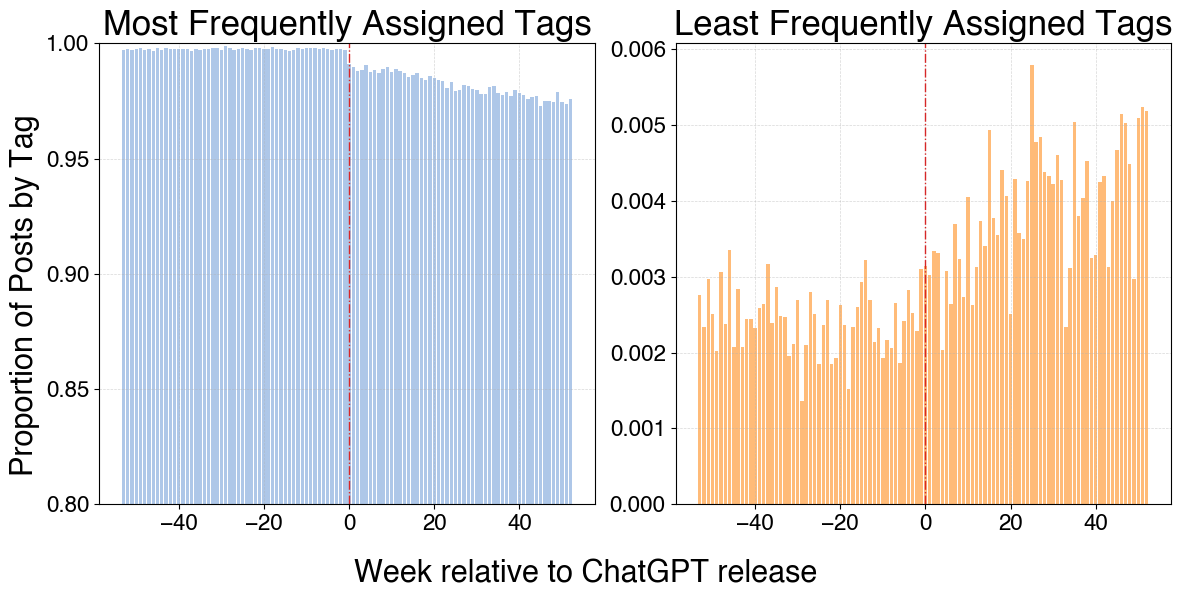

In [40]:
sharey = False ## 또는 sharey=False
sharex = True ## 또는 sharex=False
g_num  = len(proportion_dict.items())

fig, axs = plt.subplots(1, g_num, figsize = (12, 6), sharey=sharey, sharex=sharex, constrained_layout=True)
colors = plt.get_cmap('tab20').colors 

for x, (title, proportion) in enumerate(proportion_dict.items()):
    rel_week = list(proportion['rel_week'])
    values = list(proportion['pct_pct'])
    
    axs[x].bar(rel_week, values, color=colors[x*2+1])
    axs[x].axvline(x=0, color='tab:red', linestyle='-.', linewidth=1)
    axs[x].set_title(f'{title}', fontsize=25)
    axs[x].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

    if x ==0 :
        axs[x].set_ylim(0.8, 1.0)
        axs[x].set_yticks(np.arange(0.8, 1.01, 0.05))

    axs[x].tick_params(axis='x', labelsize=16)
    axs[x].tick_params(axis='y', labelsize=16)

fig.supxlabel("Week relative to ChatGPT release", fontsize=22) 
fig.supylabel("Proportion of Posts by Tag", fontsize=22) 
fig.tight_layout()
plt.savefig(f"{output_dir}Result_Fig4.png", dpi=300, bbox_inches='tight')
plt.show();

In [ ]:
df_pct_top_tot

In [ ]:
df_coef['cdate'] = pd.to_datetime(df_coef['cdate'], format="%Y-%m-%d")

In [ ]:
df_coef['post_std_diff'] = (df_coef['cdate'] - post_std_date).dt.days
df_coef['pre_std_diff'] = (df_coef['cdate'] - pre_std_date).dt.days

In [ ]:
date_range = 7*15

In [ ]:
df_coef.head()

In [ ]:
df_coef_post = df_coef[((df_coef['post_std_diff']) >=-date_range) &((df_coef['post_std_diff']) <date_range) ]
df_coef_post = df_coef_post.rename(columns = {'post_std_diff':'std_diff'})

In [ ]:
df_coef_pre = df_coef[((df_coef['pre_std_diff']) >=-date_range) &((df_coef['pre_std_diff']) <date_range) ]
df_coef_pre = df_coef_pre.rename(columns = {'pre_std_diff':'std_diff'})

In [ ]:
df_coef_post.loc[:, 'treated'] = 1
df_coef_pre.loc[:, 'treated'] = 0

In [ ]:
print(df_coef_post['cdate'].min())
print(df_coef_post['cdate'].max())
print(df_coef_pre['cdate'].min())
print(df_coef_pre['cdate'].max())

In [ ]:
df_coef_post.loc[:, 'post'] = np.where(df_coef_post['std_diff'] >=0, 1, 0)
df_coef_pre.loc[:, 'post']  = np.where(df_coef_pre['std_diff'] >=0, 1, 0)

In [ ]:
data = pd.concat([df_coef_post[['cdate', 'gini', 'entropy', 'std_diff', 'treated',
       'post']],   df_coef_pre[['cdate', 'gini', 'entropy', 'std_diff', 'treated',
       'post']]], axis= 0)

In [ ]:
data['rel_week'] = np.floor(data['std_diff']/7)

In [ ]:
print(data['rel_week'].min())
print(data['rel_week'].max())

In [ ]:
def calc_did(data, measure):
    data['rel_week'] = data['rel_week'].astype('category')
    data['std_diff'] = data['std_diff'].astype('category')
    # 회귀식: 주차별 상호작용 포함
    model = smf.ols(f"{measure} ~ C(rel_week) * treated", data=data)
    did_result = model.fit(cov_type='HAC', cov_kwds={'maxlags': 7}) 

    return did_result

In [ ]:
def pp_did_result(did_result) :
    # 결과 정리
    periods = np.arange(list(data['rel_week'].unique())[1], list(data['rel_week'].unique())[-1]+1, 1)
    coefs = did_result.params
    std_errors = did_result.bse 
    conf = did_result.conf_int()
    coefs_filtered      = coefs.loc[[f'C(rel_week)[T.{i}]:treated' for i in periods]].values
    std_errors_filtered = std_errors.loc[[f'C(rel_week)[T.{i}]:treated' for i in periods]].values

    # 신뢰구간 계산
    ll_95 = coefs_filtered - 1.965 * std_errors_filtered
    ul_95 = coefs_filtered + 1.965 * std_errors_filtered

    # 데이터프레임 생성 (계수와 신뢰구간)
    df_coefs = pd.DataFrame({
        'period'    : periods,
        'Estimate'  : coefs_filtered,
        'll_95'     : ll_95,
        'ul_95'     : ul_95
    })
    return df_coefs




In [ ]:
g_did_result = calc_did(data, 'gini')
e_did_result = calc_did(data, 'entropy')

g_event_effects = pp_did_result(g_did_result)
e_event_effects = pp_did_result(e_did_result)


In [ ]:
event_effects_dict = dict()
event_effects_dict['Gini coefficient'] = g_event_effects
event_effects_dict['Entropy'] = e_event_effects

In [ ]:
alpha_dict = {0 : 'A. ', 1 : 'B. '}

In [ ]:
colors_left = [
    "#1f77b4",  # muted blue
    "#ff7f0e",  # orange
    "#2ca02c",  # green
    "#d62728",  # red
    "#9467bd",  # purple
    "#8c564b",  # brown
    "#e377c2",  # pink
    "#7f7f7f",  # gray
    "#bcbd22",  # yellow-green
    "#17becf",  # cyan
]

colors_right = [
    "#332288", "#88CCEE", "#44AA99", "#117733", "#999933",
    "#DDCC77", "#CC6677", "#882255", "#AA4499", "#661100"
]


In [ ]:

### create a figure with multiple subplots
sharey = True ## 또는 sharey=False
sharex = True ## 또는 sharex=False
# g_num  = len(proportion_dict.items())

fig, axs = plt.subplots(1, 4, figsize = (24, 6), constrained_layout=True)
colors = plt.get_cmap('tab20').colors 


for x, (title, proportion) in enumerate(stackedbar_dict.items()):
    y_length = len(list(proportion.values())[0])
    bottom = np.array([0.0]*y_length)
    x_rel, divider = get_dist_x_div(list(proportion.values())[0])
    color_idx_list = [xx for xx in range(len(colors)) if xx % 2 == x]
    
    for idx, (topic, count) in enumerate(proportion.items()):    
        # p = axs[x].bar(x_rel, count, bottom=bottom, label=topic, color = colors[color_idx_list[idx]])
        p = axs[x].bar(x_rel, count, bottom=bottom, label=topic, color = colors_left[idx] if x==0 else colors_right[idx])
        bottom += count
    axs[x].axvline(x=0, color='tab:red', linestyle='-.', linewidth=1)
    
    # axs[x].set_ylabel("Accumulated topic share", fontsize = 22)
    axs[x].set_title(f'{title}', fontsize=25)
    axs[x].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    axs[x].set_ylim(0, 0.5)

# 신뢰구간 영역
for idx, measure in enumerate(event_effects_dict):
    idx+=2

    axs[idx].fill_between(event_effects_dict[measure]['period'], event_effects_dict[measure]['ll_95'], event_effects_dict[measure]['ul_95'], color='gray', alpha=0.3)
    axs[idx].plot(event_effects_dict[measure]['period'], event_effects_dict[measure]['Estimate'], color='black', label='DID Estimate')

    # 기준선
    axs[idx].axhline(0, linestyle='--', color='black')
    axs[idx].axvline(0, linestyle='dashdot', color='red', label='ChatGPT Release')

    # 축 라벨과 제목
    axs[idx].set_title(f"{measure}", fontsize=25)
    axs[idx].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

axs[0].tick_params(axis='x', labelsize=16)
axs[1].tick_params(axis='x', labelsize=16)
axs[2].tick_params(axis='x', labelsize=16)
axs[3].tick_params(axis='x', labelsize=16)

axs[0].tick_params(axis='y', labelsize=16)
axs[1].tick_params(axis='y', labelsize=16)
axs[2].tick_params(axis='y', labelsize=16)
axs[3].tick_params(axis='y', labelsize=16)

axs[0].set_ylabel("Accumulated topic share", fontsize = 22)
axs[2].set_ylabel(f"Effect and 95% CI", fontsize = 22)

fig.supxlabel("Week relative to ChatGPT release", fontsize=22) 

plt.savefig(f"{output_dir}C_Result_Fig2.png", dpi=300, bbox_inches='tight')
plt.show();

In [ ]:
colors = plt.get_cmap('tab20').colors 



In [ ]:
color_idx = [xx for xx in range(len(colors)) if xx % 2 == 1]

In [ ]:
color_idx